# 2. Поиск сайтов протеолиза белков протеосомой по данным VDJdb<cite id="douc2"><a href="#zotero%7C13080035%2FJ9SN38RQ">(Bagaev et al., 2020)</a></cite>

Антон Смирнов, 20.01.2023

# Предварительные настройки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from datetime import datetime
from urllib.error import HTTPError
from Bio import Entrez, SeqIO
from io import StringIO
import logomaker
import re

**Всегда говори NCBI кто ты**

In [2]:
Entrez.email = "anton.smirnov.9910@gmail.com"
Entrez.api_key = "67a161eb14f134f9d7e50e111f957429f808"

In [3]:
# Print iterations progress
def printProgressBar (iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█', printEnd = "\r"):
    """
    Call in a loop to create terminal progress bar
    @params:
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : positive number of decimals in percent complete (Int)
        length      - Optional  : character length of bar (Int)
        fill        - Optional  : bar fill character (Str)
        printEnd    - Optional  : end character (e.g. "\r", "\r\n") (Str)
    """
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print(f'\r{prefix} |{bar}| {percent}% {suffix}', end = printEnd)
    # Print New Line on Complete
    if iteration == total:
        print()

In [4]:
def isCorrectSequence(seq):
    alphabet = list("ACDEFGHIKLMNPQRSTVWY")
    seq = seq.strip()
    for i in range(0,len(seq)):
        if seq[i] not in alphabet:
            return False
    return True

Для описания сайтов разрезания берем С-конец эпитопа. Для полноты картины нужна аминокислота, следующая после С-конца эпитопа. Для этого нужна референсная последовательность и большая часть кода посвящена их извлечению.

In [5]:
vdjdb = pd.read_csv("../data/source/VDJdb-2022-11-13-22-41.tsv", sep = "\t", header=0)
vdjdb.head()

,complex.id,Gene,CDR3,V,J,Species,MHC A,MHC B,MHC class,Epitope,Epitope gene,Epitope species,Reference,Method,Meta,CDR3fix,Score
0,1,TRA,CIVRAPGRADMRF,TRAV26-1*01,TRAJ43*01,HomoSapiens,HLA-B*08,B2M,MHCI,FLKEKGGL,Nef,HIV-1,PMID:15596521,"{""frequency"": """", ""identification"": ""tetramer-...","{""cell.subset"": ""CD8+"", ""clone.id"": """", ""donor...","{""cdr3"": ""CIVRAPGRADMRF"", ""cdr3_old"": ""CIVRAPG...",2
1,1,TRB,CASSYLPGQGDHYSNQPQHF,TRBV13*01,TRBJ1-5*01,HomoSapiens,HLA-B*08,B2M,MHCI,FLKEKGGL,Nef,HIV-1,PMID:15596521,"{""frequency"": """", ""identification"": ""tetramer-...","{""cell.subset"": ""CD8+"", ""clone.id"": """", ""donor...","{""cdr3"": ""CASSYLPGQGDHYSNQPQHF"", ""cdr3_old"": ""...",2
2,0,TRB,CASSFEAGQGFFSNQPQHF,TRBV13*01,TRBJ1-5*01,HomoSapiens,HLA-B*08,B2M,MHCI,FLKEKGGL,Nef,HIV-1,PMID:15596521,"{""frequency"": """", ""identification"": ""tetramer-...","{""cell.subset"": ""CD8+"", ""clone.id"": """", ""donor...","{""cdr3"": ""CASSFEAGQGFFSNQPQHF"", ""cdr3_old"": ""C...",2
3,2,TRA,CAVPSGAGSYQLTF,TRAV20*01,TRAJ28*01,HomoSapiens,HLA-B*08,B2M,MHCI,FLKEKGGL,Nef,HIV-1,PMID:15596521,"{""frequency"": """", ""identification"": ""tetramer-...","{""cell.subset"": ""CD8+"", ""clone.id"": """", ""donor...","{""cdr3"": ""CAVPSGAGSYQLTF"", ""cdr3_old"": ""CAVPSG...",2
4,2,TRB,CASSFEPGQGFYSNQPQHF,TRBV13*01,TRBJ1-5*01,HomoSapiens,HLA-B*08,B2M,MHCI,FLKEKGGL,Nef,HIV-1,PMID:15596521,"{""frequency"": """", ""identification"": ""tetramer-...","{""cell.subset"": ""CD8+"", ""clone.id"": """", ""donor...","{""cdr3"": ""CASSFEPGQGFYSNQPQHF"", ""cdr3_old"": ""C...",2


In [73]:
len(vdjdb['Epitope'].unique())

1150

## Первичная фильтрация

Сайты разрезания ищем только для человеческих МНС 1 класса

In [6]:
vdjdb_filtered = vdjdb[vdjdb["MHC class"] == "MHCI"]
vdjdb_filtered.shape

(86160, 17)

In [7]:
vdjdb_filtered = vdjdb_filtered[vdjdb_filtered["Species"] == "HomoSapiens"]
vdjdb_filtered.shape

(78770, 17)

Оставляем с нормально записанной последовательностью и не пустыми полями про источник

In [8]:
vdjdb_filtered = vdjdb_filtered[vdjdb_filtered["Epitope"].apply(isCorrectSequence)]
vdjdb_filtered.shape

(78770, 17)

In [9]:
vdjdb_filtered = vdjdb_filtered[~vdjdb_filtered["Epitope gene"].isna()]
vdjdb_filtered.shape

(78738, 17)

In [10]:
vdjdb_filtered = vdjdb_filtered[~vdjdb_filtered["Epitope species"].isna()]
vdjdb_filtered.shape

(78738, 17)

In [11]:
vdjdb_filtered = vdjdb_filtered[~vdjdb_filtered["Reference"].isna()]
vdjdb_filtered.shape

(77227, 17)

## Очистка

### Названия генов

In [12]:
print(vdjdb_filtered["Epitope gene"].unique())

['Nef' 'pp65' 'Nucleocapsid' 'ORF3' 'ORF1ab' 'Spike' 'NDC1' 'TKT' 'SEC24A'
 'AKAP13' 'EXOC8' 'PABPC1' 'MLANA' 'BRLF1' 'Gag' 'IE1' 'EBNA1' 'BZLF1'
 'Tax' 'EBNA3A' 'M' 'NY-ESO-1' 'UL40' 'EBNA6' 'Tel1' 'ABCD3' 'BMLF1'
 'ELAVL4' 'INS' 'Pol' 'TERT' 'NS3' 'EMC' 'WT1' 'MAGE-A3' 'TITIN'
 'synthetic' 'M1-F5L' 'M1-G4E' 'GAG' 'Leader peptide' 'RT' 'NP338'
 'ANKRD30A' 'MAGE-A4' 'PMEL' 'P53' 'ENR' 'TP53' 'PIK3CA' 'NS4B' 'BST2'
 'IE2' 'UL49' 'NSP3' 'INS-DRiP' 'PTPRN' 'EBNA4' 'EBNA3B' 'pp50' 'NP'
 'LMP2A' 'T-Ag' '5T4' 'GANAB' 'GNL3L' 'PGM5' 'SNX24' 'FNDC3B' 'SMARCD3'
 'CDK4' 'NS5B' 'SLC30A8' 'KRAS' 'MAGEA6' 'PDS5A' 'MED13' 'RFC5' 'BRAP'
 'GINS1' 'DPY19L4' 'RNF19B' 'ASTN1' 'MLL2' 'BCL2L1' 'PLA2G6' 'E7' 'LMP1'
 'MAGEA1' 'TYR' 'KanJ' 'MAGEA3' 'KLK3' 'PLCD3' 'PPM1' 'SRPX' 'AHNAK'
 'AFMID' 'HELZ2' 'CENPL' 'TPX2' 'WDR46' 'HIVEP2' 'AMPH' 'Vpr' 'Vif'
 'Matrix' 'RNP' 'NSP12' 'TXNDC11' 'U2AF2' 'GEMIN' 'CD74' 'PDE4A' 'WDR87'
 'FANCI' 'CRISPLD1' 'KLHL7' 'ARMT1' 'gp100' 'SSX2' 'MAGE-A1' 'ABCB5'
 'MART1' 'Tyrosina

Исключим синтетические конструкты

In [13]:
vdjdb_filtered = vdjdb_filtered[vdjdb_filtered["Epitope gene"] != "synthetic"]
vdjdb_filtered.shape

(77161, 17)

Есть ли эпитопы, которые пришли из разных генов?

In [14]:
epitopes = vdjdb_filtered["Epitope"].unique()
for e in epitopes:
    v = vdjdb_filtered[vdjdb_filtered["Epitope"] == e]
    if len(v["Epitope gene"].unique()) > 1:
        print(f"{e} {v['Epitope gene'].unique()}")

IPLTEEAEL ['RT' 'Pol']
APRGPHGGAASGL ['NY-ESO-1' 'NY-ESO']
HMTEVVRHC ['P53' 'TP53' 'p53']


Исправляем аннотацию

In [15]:
vdjdb_filtered.loc[vdjdb_filtered["Epitope gene"].str.contains("RT"),"Epitope gene"] = "Pol"
vdjdb_filtered.loc[vdjdb_filtered["Epitope gene"].str.contains("NY-ESO"),"Epitope gene"] = "NY-ESO-1"
vdjdb_filtered.loc[vdjdb_filtered["Epitope gene"].str.contains("P53"),"Epitope gene"] = "TP53"
vdjdb_filtered.loc[vdjdb_filtered["Epitope gene"].str.contains("p53"),"Epitope gene"] = "TP53"

### Названия видов

In [16]:
print(vdjdb_filtered["Epitope species"].unique())

['HIV-1' 'CMV' 'SARS-CoV-2' 'HomoSapiens' 'EBV' 'HTLV-1' 'InfluenzaA'
 'SaccharomycesCerevisiae' 'HCV' 'synthetic' 'DENV1' 'DENV3/4'
 'M.tuberculosis' 'HIV1' 'Homo sapiens' 'YFV' 'HSV-2' 'DENV2' 'MCPyV'
 'HPV' 'StreptomycesKanamyceticus' 'HIV' 'HCoV-HKU1']


Исключим синтетические конструкты


In [17]:
vdjdb_filtered = vdjdb_filtered[vdjdb_filtered["Epitope species"] != "synthetic"]
vdjdb_filtered.shape

(77157, 17)

Исправляем аннотацию

In [18]:
vdjdb_filtered.loc[vdjdb_filtered["Epitope species"].str.contains("HIV"),"Epitope species"] = "HIV-1"
vdjdb_filtered.loc[vdjdb_filtered["Epitope species"].str.contains("HSV-2"),"Epitope species"] = "HSV2"
vdjdb_filtered.loc[vdjdb_filtered["Epitope species"].str.contains("EBV"),"Epitope species"] = "Human gammaherpesvirus 4"
vdjdb_filtered.loc[vdjdb_filtered["Epitope species"].str.contains("CMV"),"Epitope species"] = "Human betaherpesvirus 5"
vdjdb_filtered.loc[vdjdb_filtered["Epitope species"].str.contains("HomoSapiens"),"Epitope species"] = "Homo sapiens"
vdjdb_filtered.loc[vdjdb_filtered["Epitope species"].str.contains("SaccharomycesCerevisiae"),"Epitope species"] = "Saccharomyces cerevisiae"
vdjdb_filtered.loc[vdjdb_filtered["Epitope species"].str.contains("StreptomycesKanamyceticus"),"Epitope species"] = "Streptomyces kanamyceticus"
vdjdb_filtered.loc[vdjdb_filtered["Epitope species"].str.contains("M.tuberculosis"),"Epitope species"] = "Mycobacterium tuberculosis"
vdjdb_filtered.loc[vdjdb_filtered["Epitope species"].str.contains("HPV"),"Epitope species"] = "Human papillomavirus"
vdjdb_filtered.loc[vdjdb_filtered["Epitope species"].str.contains("DENV1"),"Epitope species"] = "Dengue virus 1"
vdjdb_filtered.loc[vdjdb_filtered["Epitope species"].str.contains("DENV2"),"Epitope species"] = "Dengue virus 2"
vdjdb_filtered.loc[vdjdb_filtered["Epitope species"].str.contains("InfluenzaA"),"Epitope species"] = "Influenza A virus"
vdjdb_filtered.loc[vdjdb_filtered["Epitope species"].str.contains("MCPyV"),"Epitope species"] = "Merkel cell polyomavirus"

In [19]:
vdjdb_filtered = vdjdb_filtered[vdjdb_filtered["Epitope species"] != "DENV3/4"]

In [20]:
print(vdjdb_filtered["Epitope species"].unique())

['HIV-1' 'Human betaherpesvirus 5' 'SARS-CoV-2' 'Homo sapiens'
 'Human gammaherpesvirus 4' 'HTLV-1' 'Influenza A virus'
 'Saccharomyces cerevisiae' 'HCV' 'Dengue virus 1'
 'Mycobacterium tuberculosis' 'YFV' 'HSV2' 'Dengue virus 2'
 'Merkel cell polyomavirus' 'Human papillomavirus'
 'Streptomyces kanamyceticus' 'HCoV-HKU1']


## Описательная статистика

In [21]:
vdjdb_filtered["Epitope species"].value_counts().reset_index().loc[0:4]

,index,Epitope species
0,Human betaherpesvirus 5,37945
1,Human gammaherpesvirus 4,11291
2,Influenza A virus,10509
3,SARS-CoV-2,7135
4,Homo sapiens,4870


In [22]:
vdjdb_filtered["Species"].value_counts()

HomoSapiens    76978
Name: Species, dtype: int64

In [23]:
vdjdb_filtered["Epitope gene"].value_counts()

IE1        28142
M          10038
pp65        8941
EBNA4       5032
Spike       2896
           ...  
TUBGCP2        1
KARS           1
CADPS2         1
CDKN2A         1
PHLPP1         1
Name: Epitope gene, Length: 168, dtype: int64

In [24]:
vdjdb_filtered["Score"].value_counts()

0    69400
1     4575
2     1584
3     1419
Name: Score, dtype: int64

In [25]:
print(max(vdjdb_filtered["Epitope"].str.len()))

20


In [26]:
epitopes = vdjdb_filtered["Epitope"].unique()

In [29]:
len(epitopes)

959

In [27]:
probs = pd.DataFrame(np.zeros_like(0,shape = (20,20)), index = list("ACDEFGHIKLMNPQRSTVWY"))
for i in epitopes:
    amk = list(i)
    for j,a in enumerate(amk):
        probs.loc[a,j] += 1
probs = probs.T / len(epitopes)
probs

,A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y
0,0.069864,0.021898,0.013556,0.032325,0.104275,0.033368,0.018770,0.056309,0.074035,0.105318,0.042753,0.036496,0.007299,0.022941,0.070907,0.061522,0.068822,0.066736,0.021898,0.070907
1,0.034411,0.004171,0.010428,0.014599,0.023983,0.009385,0.005214,0.057351,0.006257,0.337852,0.063608,0.002086,0.130344,0.027112,0.010428,0.049009,0.079249,0.088634,0.008342,0.037539
2,0.085506,0.020855,0.117831,0.041710,0.061522,0.037539,0.015641,0.047967,0.025026,0.111575,0.033368,0.069864,0.042753,0.021898,0.038582,0.061522,0.040667,0.047967,0.029197,0.049009
3,0.067779,0.017727,0.070907,0.069864,0.042753,0.095933,0.021898,0.044838,0.041710,0.078206,0.019812,0.057351,0.070907,0.033368,0.027112,0.072993,0.054223,0.051095,0.023983,0.037539
4,0.047967,0.025026,0.040667,0.034411,0.079249,0.055266,0.026069,0.060480,0.046924,0.122002,0.026069,0.043796,0.032325,0.023983,0.040667,0.069864,0.065693,0.088634,0.018770,0.052138
5,0.079249,0.028154,0.042753,0.020855,0.060480,0.061522,0.013556,0.072993,0.018770,0.114703,0.027112,0.035454,0.057351,0.032325,0.029197,0.068822,0.088634,0.091762,0.018770,0.037539
6,0.089677,0.015641,0.042753,0.028154,0.079249,0.057351,0.022941,0.045881,0.044838,0.116788,0.033368,0.047967,0.047967,0.043796,0.028154,0.052138,0.061522,0.074035,0.025026,0.042753
7,0.070907,0.017727,0.025026,0.051095,0.059437,0.052138,0.027112,0.042753,0.036496,0.134515,0.022941,0.039625,0.047967,0.033368,0.033368,0.070907,0.085506,0.066736,0.013556,0.067779
8,0.067779,0.018770,0.008342,0.004171,0.063608,0.012513,0.009385,0.082377,0.022941,0.234619,0.026069,0.007299,0.007299,0.016684,0.005214,0.014599,0.039625,0.233577,0.011470,0.094891
9,0.006257,0.001043,0.001043,0.003128,0.005214,0.002086,0.000000,0.004171,0.012513,0.019812,0.005214,0.001043,0.000000,0.001043,0.002086,0.002086,0.003128,0.022941,0.001043,0.010428


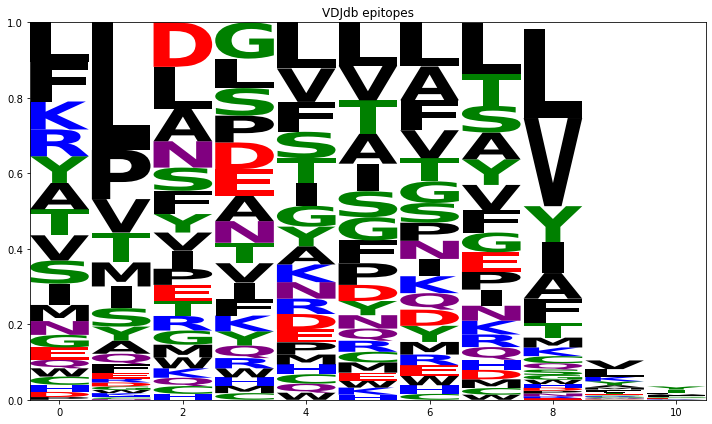

In [28]:
#logo = logomaker.Logo(probs,color_scheme = "chemistry")
fig,ax = plt.subplots(figsize = (10,6))
ax.set_title("VDJdb epitopes")
logo = logomaker.Logo(probs.iloc[0:11,:], color_scheme = "chemistry", ax = ax)
fig.tight_layout()

In [77]:
vdjdb_filtered["Epitope"].str.len().median()

9.0

Ожидается, что большинство эпитопов имеют в качестве сайта разрезания лейцин или валин, так как они более представлены в датасете. Но в целом, наблюдается более менее равномерное распределение аминокислот на каждой позиции.

## Поиск референсных последовательностей

Формирования множества запросов

In [30]:
uni_gene_spec = vdjdb_filtered[["Epitope gene","Epitope species"]].drop_duplicates()
uni_gene_spec.shape

(172, 2)

In [32]:
queries = set()
for i in uni_gene_spec.index:
    s = f"({uni_gene_spec.loc[i, 'Epitope gene']}) AND (\"{uni_gene_spec.loc[i, 'Epitope species']}\" [Organism])"
    queries.add(s)
print(len(queries))

172


Проверка на то, что запросы ищут все эпитопы

In [33]:
epi_ids = []
epi_num = 0
for k, q in enumerate(queries):
    gene = re.split("\((.*?)\)",q)[1]
    organism = re.split("\"",q)[1]
    epi = list(vdjdb_filtered.loc[(vdjdb_filtered["Epitope gene"] == gene) &
                                (vdjdb_filtered["Epitope species"] == organism), "Epitope"].unique())
    epi_num += len(epi)
    for e in epi:
        #print(e)
        epi_id = e#f"{e}_{gene}_{organism}"
        if epi_id not in epi_ids: 
            epi_ids.append(epi_id)
        else:
            print(epi_id)
print(f"ids {len(epi_ids)} epi_total {len(epitopes)} epi_num {epi_num}")

ids 959 epi_total 959 epi_num 959


Ищет и сохраняет последовательности на NCBI Protein, если в ней найден эпитоп. Код выполняется некоторое время. Готовый файл называется vdjdb_seqs.fasta в папке data. **Не запускайте этот блок без необходимости.**

In [281]:
seqs = {}
tries = 10
total = len(queries)
failed_queries = {}
epi_failed = 0
printProgressBar(0,total,length = 40, suffix = f"failed: 0 success: 0")
with open("../data/vdjdb_seqs_ref_new.fasta","w") as fasta:
    for k, q in enumerate(queries):
        gene = re.split("\((.*?)\)",q)[1]
        organism = re.split("\"",q)[1]
        epi = list(vdjdb_filtered.loc[(vdjdb_filtered["Epitope gene"] == gene) &
                                (vdjdb_filtered["Epitope species"] == organism), "Epitope"].unique())
        search_res = Entrez.read(Entrez.esearch(db="protein", retmax=100, term=q))["IdList"]
        if organism == "SARS-CoV-2":
            # количество последовательностей для ковида очень велико
            search_res = Entrez.read(Entrez.esearch(db="protein", retmax=20000, term=q))["IdList"]
        handle = Entrez.efetch(id = ",".join(search_res), db = "protein", rettype="fasta", retmode="text")
        fasta_io = StringIO(handle.read())
        for record in SeqIO.parse(fasta_io, "fasta"):
            for e in epi:
                if e in record.seq:
                    epi_id = f"{e}_{gene}_{organism}"
                    record.id = epi_id
                    seqs[epi_id] = record.seq
                    SeqIO.write(record, fasta, "fasta")
                    epi.remove(e)
            if len(epi) == 0:
                break
        if len(epi) != 0:
            failed_queries[q] = {"epi":epi,"max_epi":f"{len(epi)}"}
            epi_failed += len(epi)
        printProgressBar(k,total, suffix = f"failed: {epi_failed} success:{len(seqs.values())}",length = 40)

 |███████████████████████████████████████-| 99.4% failed: 225 success:734
734
942


# Результаты

При повторном запуске блокнота, используйте этот код

In [44]:
seqs = {}
success_epitopes = []
with open("../data/vdjdb_seqs.fasta", "r") as fasta:
    for record in SeqIO.parse(fasta, "fasta"):
        seqs[record.id] = record.seq
        success_epitopes.append(re.split("_",record.id)[0])
print(len(seqs.keys()))

734


In [36]:
failed_epitopes = vdjdb_filtered[~vdjdb_filtered["Epitope"].isin(success_epitopes)]
failed_epitopes.shape

(6108, 17)

In [37]:
failed_stat = failed_epitopes[["Epitope","Epitope gene","Epitope species"]].drop_duplicates()
failed_stat.shape

(225, 3)

In [38]:
failed_stat.head()

,Epitope,Epitope gene,Epitope species
16,FLKETGGL,Nef,HIV-1
23,FLKEMGGL,Nef,HIV-1
433,ALSKGVHFV,ORF3,SARS-CoV-2
483,CLNEYHLFL,NDC1,Homo sapiens
493,AMFWSVPTV,TKT,Homo sapiens


Большинство ненайденных эпитопов - человеческие и нового короновируса. Возможно эпитопы являются довольно редкими вариантами.

In [39]:
failed_stat["Epitope species"].value_counts()

Homo sapiens                  98
SARS-CoV-2                    91
HIV-1                         11
Human gammaherpesvirus 4      11
HTLV-1                         6
Human betaherpesvirus 5        3
HCV                            2
Influenza A virus              1
Mycobacterium tuberculosis     1
Streptomyces kanamyceticus     1
Name: Epitope species, dtype: int64

In [41]:
all_stat = vdjdb_filtered[["Epitope","Epitope gene","Epitope species"]].drop_duplicates()
all_stat["Epitope species"].value_counts()

SARS-CoV-2                    659
Homo sapiens                  157
HIV-1                          49
Human gammaherpesvirus 4       30
Human betaherpesvirus 5        29
HTLV-1                          8
Influenza A virus               7
HCV                             7
Mycobacterium tuberculosis      3
Merkel cell polyomavirus        2
Dengue virus 2                  1
Streptomyces kanamyceticus      1
Human papillomavirus            1
Dengue virus 1                  1
HSV2                            1
YFV                             1
Saccharomyces cerevisiae        1
HCoV-HKU1                       1
Name: Epitope species, dtype: int64

In [67]:
combinations = {}
ff = {}
for key, seq in seqs.items():
    e = re.split("_",key)[0]
    e_start = seq.find(e)
    #print(f"{e_start} {len(seq)}")
    #print(seq[e_start + len(e)])
    if e_start + len(e) < len(seq):
        C_end = seq[e_start + len(e)]
    else:
        ff[e] = key
        continue
    combinations[e] = e[-1] + C_end
df_comb = pd.DataFrame.from_dict(combinations, orient = "index",columns = ["Comb"])
print(df_comb.shape)
df_comb.head()

(727, 1)


,Comb
ARMILMTHF,FF
KIFGSLAFL,LP
VLNGTVHPV,VF
MLWGYLQYV,VG
FRCPRRFCF,FS


Часть эпитопов равна по величине референсу

In [65]:
ff

{'ILDQVPFSV': 'ILDQVPFSV_PMEL_Homo',
 'IMDQVPFSV': 'IMDQVPFSV_PMEL_Homo',
 'SLLMWITQV': 'SLLMWITQV_NY-ESO-1_Homo',
 'VMAPRTLVL': 'VMAPRTLVL_Leader',
 'ALHGGWTTK': 'ALHGGWTTK_PIK3CA_Homo',
 'AVGSYVYSV': 'AVGSYVYSV_PGM5_Homo',
 'ILDTAGKEEY': 'ILDTAGKEEY_NRAS_Homo'}

In [68]:
success_stat = vdjdb_filtered.loc[vdjdb_filtered["Epitope"].isin(success_epitopes) & (~vdjdb_filtered["Epitope"].isin(ff.keys())),["Epitope","Epitope gene","Epitope species"]].drop_duplicates()
success_stat.shape

(727, 3)

Частоты встречаемости аминокислот в N-конце сайта разрезания

<AxesSubplot:>

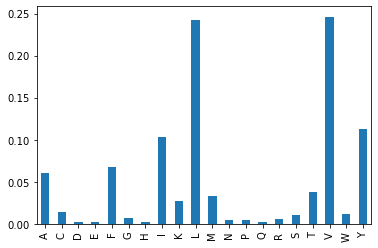

In [69]:
(success_stat["Epitope"].str[-1].value_counts().sort_index() / len(success_stat.index)).plot.bar()

In [70]:
df_comb.value_counts()

Comb
LL      20
VL      20
LV      14
VY      14
VD      13
        ..
FY       1
FH       1
FE       1
NK       1
AC       1
Length: 190, dtype: int64

Тот же график для С-конца сайта

<AxesSubplot:>

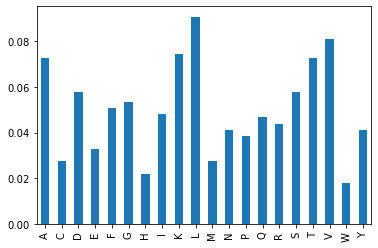

In [72]:
(df_comb["Comb"].str[1].value_counts().sort_index() / len(df_comb.index)).plot.bar()

**Можно сделать вывод, что не так важна аминокислота, идущая после сайта связывания, как перед ним.**

<!-- BIBLIOGRAPHY START -->
<div class="csl-bib-body">
  <div class="csl-entry"><i id="zotero|13080035/J9SN38RQ"></i>Bagaev, D. V., Vroomans, R. M. A., Samir, J., Stervbo, U., Rius, C., Dolton, G., Greenshields-Watson, A., Attaf, M., Egorov, E. S., Zvyagin, I. V., Babel, N., Cole, D. K., Godkin, A. J., Sewell, A. K., Kesmir, C., Chudakov, D. M., Luciani, F., &#38; Shugay, M. (2020). VDJdb in 2019: database extension, new analysis infrastructure and a T-cell receptor motif compendium. <i>Nucleic Acids Research</i>, <i>48</i>(D1), D1057–D1062. <a href="https://doi.org/10.1093/nar/gkz874">https://doi.org/10.1093/nar/gkz874</a></div>
</div>
<!-- BIBLIOGRAPHY END -->